__Tratamento dos Dados__

In [1]:
import pandas as pd

# Ler CSV
df = pd.read_csv('sao-paulo-properties-april-2019.csv')

# Filtrar somente casos de aluguel
df = df.loc[df['Negotiation Type'] == 'rent'].reset_index(drop = True)

# Remover colunas indesejadas
df.drop(['Negotiation Type','Property Type','New','Latitude', 'Longitude'], axis=1, inplace=True)

# Gerar one-hot para facilitar o entendimento do algoritmo em relação ao bairro do apto.
one_hot = pd.get_dummies(df['District'])

# Unir DataFrames
df = df.join(one_hot)

# Remover coluna District após o join com o one_hot
df.drop('District', axis=1, inplace=True)


# Calcular a matriz de correlação
correlacao = df.iloc[:,0:10].corr()
correlacao['Price'].sort_values(ascending=False)

Price            1.000000
Size             0.731795
Condo            0.700361
Parking          0.640743
Suites           0.588329
Toilets          0.583488
Rooms            0.390951
Swimming Pool    0.206884
Furnished        0.171859
Elevator         0.031860
Name: Price, dtype: float64

**Definir quais serão os dados que serão utilizados no treino dos algoritmos**

In [2]:
from sklearn.model_selection import train_test_split

# Definir x para as features (variáveis independentes que influenciam o target)
x = df.loc[:,df.columns != 'Price'] # Features removendo o target

# Definir y para os valores Target, os quais o algoritmo deve chegar o mais próximo possível
y = df['Price'] # Target

# Dividir o DataFrame entre 70% para treino e 30% teste
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3)

**Construir algoritmo usando Regressão Linear**

In [3]:
from sklearn.linear_model import LinearRegression

# Instanciar LinearRegression() como objeto para ser chamado no futuro 
lin_reg = LinearRegression()

# Inserir os dados no objeto LinearRegression()
lin_reg.fit(x_train, y_train)

# Aqui o objeto LinearRegression calcula as predições de preço usando os dados separados em x_train
predições_lin_reg = lin_reg.predict(x_train)

df_comparacao = pd.DataFrame({
    "Valor Esperado": y_train,
    "Valor Predito": predições_lin_reg,
    "Diferença" : (predições_lin_reg/y_train)-1
})

# # Exibir os casos que tiveram diferença 
# df_comparacao.loc[df_comparacao['Valor Esperado'] != df_comparacao['Valor Predito']]


**Construir algoritmo usando Regressão de Árvore de Decisão**

In [4]:
from sklearn.tree import DecisionTreeRegressor

# Instanciar o método DecisionTreeRegressor para ser chamado novamente no futuro
tree_reg = DecisionTreeRegressor()

# Inserir os dados no objeto DecisionTreeRegressor e realizar o cálculo
tree_reg.fit(x_train, y_train)

predições_tree_reg = tree_reg.predict(x_train)

df_comparacao = pd.DataFrame({
    "Valor Esperado": y_train,
    "Valor Predito": predições_tree_reg,
    "Diferença" : (predições_tree_reg/y_train)-1
})

# # Exibir os casos que tiveram diferença 
# df_comparacao.loc[df_comparacao['Valor Esperado'] != df_comparacao['Valor Predito']]


**Calcular a eficiência do algoritmo de Regressão Linear usando o método RMSE**

In [5]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Aqui usamos o método de erro médio quadrático para calcular o quão acertivo está o algoritmo
lin_mse = mean_squared_error(y_train, predições_lin_reg)

# Por fim, precisamos calcular a raiz quadrada do resultado do método MSE para chegar a uma perspectiva do erro que o algoritmo está cometendo em relação às predições de preço
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

1936.7683454701535


**Calcular a eficiência do algoritmo de Árvore de Regressão usando o método RMSE**

In [6]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Aqui usamos o método de erro médio quadrático para calcular o quão acertivo está o algoritmo
tree_reg_mse = mean_squared_error(y_train, predições_tree_reg)

# Por fim, precisamos calcular a raiz quadrada do resultado do método MSE para chegar a uma perspectiva do erro que o algoritmo está cometendo em relação às predições de preço
tree_reg_rmse = np.sqrt(tree_reg_mse)
print(tree_reg_rmse)

47.69673835363394


**Cross Validation**

In [7]:
from sklearn.model_selection import cross_val_score


scores = cross_val_score(tree_reg, x_train, y_train, scoring="neg_mean_squared_error", cv = 10)
tree_rmse_scores = np.sqrt(-scores)

tree_rmse_scores

print("Média do RMSE:", tree_rmse_scores.mean())
print("Desvio padrão do RMSE:", tree_rmse_scores.std())

Média do RMSE: 2538.781398381522
Desvio padrão do RMSE: 314.57967798283295


In [8]:
from sklearn.model_selection import cross_val_score


scores = cross_val_score(tree_reg, x_train, y_train, scoring="neg_mean_squared_error", cv = 10)
lin_reg_rmse_scores = np.sqrt(-scores)

lin_reg_rmse_scores

print("Média do RMSE:", lin_reg_rmse_scores.mean())
print("Desvio padrão do RMSE:", lin_reg_rmse_scores.std())

Média do RMSE: 2545.2907988681604
Desvio padrão do RMSE: 298.8750678877391


**Calcular semelhança entre predições e realidade**

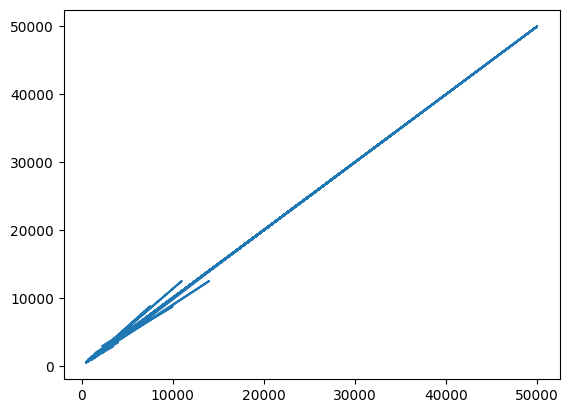

In [9]:
from matplotlib import pyplot as plt

df_comparacao = pd.DataFrame({
    "Valor Esperado": y_train,
    "Valor Predito": predições_tree_reg,
    "Diferença" : (predições_tree_reg/y_train)-1
})

x = df_comparacao['Valor Esperado']
y = df_comparacao['Valor Predito']

plt.plot(x,y)


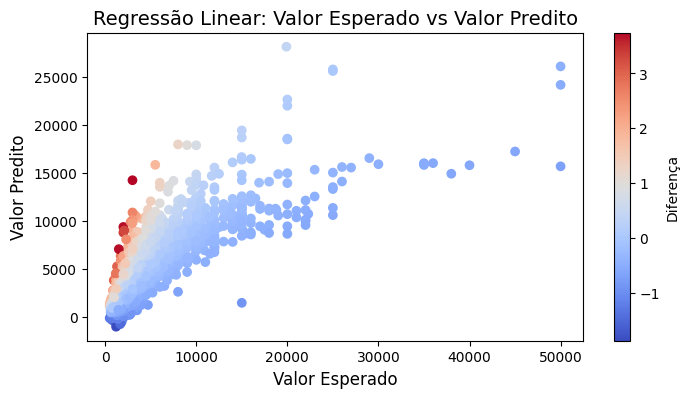

In [14]:
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt

df_comparacao = pd.DataFrame({
    "Valor Esperado": y_train,
    "Valor Predito": predições_lin_reg,
    "Diferença" : (predições_lin_reg/y_train)-1
})

# Exibir os casos que tiveram diferença 
df_comparacao = df_comparacao.loc[df_comparacao['Valor Esperado'] != df_comparacao['Valor Predito']]

# Gerar o gráfico de dispersão
plt.figure(figsize=(8, 4))
plt.scatter(
    df_comparacao["Valor Esperado"], 
    df_comparacao["Valor Predito"], 
    c=df_comparacao["Diferença"],  # Opcional: colorir os pontos com base na "Diferença"
    cmap="coolwarm"  # Define um mapa de cores
)

# Adicionar título e rótulos aos eixos
plt.title("Regressão Linear: Valor Esperado vs Valor Predito", fontsize=14)
plt.xlabel("Valor Esperado", fontsize=12)
plt.ylabel("Valor Predito", fontsize=12)

# Mostrar a barra de cores (se colorir os pontos)
plt.colorbar(label="Diferença")

# Exibir o gráfico
plt.show()

**Visualizar erros e acertos do algoritmo no gráfico de dispersão**

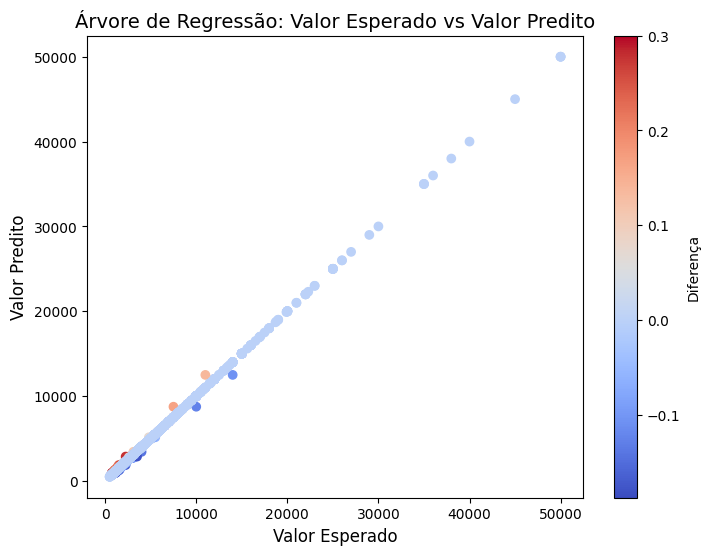

In [11]:
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt

df_comparacao = pd.DataFrame({
    "Valor Esperado": y_train,
    "Valor Predito": predições_tree_reg,
    "Diferença" : (predições_tree_reg/y_train)-1
})


# Exibir os casos que tiveram diferença 
# df_comparacao = df_comparacao.loc[df_comparacao['Valor Esperado'] != df_comparacao['Valor Predito']]

# Gerar o gráfico de dispersão
plt.figure(figsize=(8, 6))
plt.scatter(
    df_comparacao["Valor Esperado"], 
    df_comparacao["Valor Predito"], 
    c=df_comparacao["Diferença"],  # Opcional: colorir os pontos com base na "Diferença"
    cmap="coolwarm"  # Define um mapa de cores
)

# Adicionar título e rótulos aos eixos
plt.title("Árvore de Regressão: Valor Esperado vs Valor Predito", fontsize=14)
plt.xlabel("Valor Esperado", fontsize=12)
plt.ylabel("Valor Predito", fontsize=12)

# Mostrar a barra de cores (se colorir os pontos)
plt.colorbar(label="Diferença")

# Exibir o gráfico
plt.show()